In [6]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import rc

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import sys
import math
import pickle


import itertools



In [7]:

#FUNCTION
def partition_N(n):
    '''do the partition of a complete graph'''
    indexs = range(n)
    pairs_all = []

    swap_even = [i + pow(-1, i) for i in range(n)]

    swap_odd = [0]
    swap_odd.extend([i + pow(-1, i+1) for i in range(1,n-1)])
    swap_odd.append(n-1)

    pairs_even = [(i, i+1) for i in range(0, n, 2)]
    indexs = np.array(indexs)[swap_even]   ### indexs after swap even
    #     print('\nindexs after swap {}: {}'.format(0, indexs))
    pairs_all.append(pairs_even)
    for i in range(1, n):
        if (i%2)==1:
            pair_odd = [(indexs[i], indexs[i+1]) for i in range(1, n-1, 2)]
            pairs_all.append(pair_odd)
            indexs = np.array(indexs)[swap_odd]   ### indexs after swap even
    #             print('\nindexs after swap {}: {}'.format(i, indexs))

        elif (i%2)==0:
            pair_even = [(indexs[i], indexs[i+1]) for i in range(0, n-1, 2)]
            pairs_all.append(pair_even)
            indexs = np.array(indexs)[swap_even]   ### indexs after swap even
    #             print('\nindexs after swap {}: {}'.format(i, indexs))

    return pairs_all


In [8]:
def compute_cvar(probabilities, values, alpha):
    """
    Auxilliary method to compute the conditional value at risk.

    Args:
        probabilities (List[Real]): The probabilities for measuring a bit string
        values (List[Real]): The corresponding energy values
        alpha (Real): Confidence level for the conditional value at risk

    Returns:
        cvar (Real): The conditional value at risk
    """
    
    sorted_indices = np.argsort(values)
    probs = np.array(probabilities)[sorted_indices]
    vals = np.array(values)[sorted_indices]

    cvar = 0
    total_prob = 0
    for i, (p, v) in enumerate(zip(probs, vals)):
        if p >= alpha - total_prob:
            p = alpha - total_prob
        total_prob += p
        cvar += p * v
        if abs(total_prob - alpha) < 1e-8:
            break

    cvar /= total_prob

    return cvar

# Iterative Random


tau =  0.3 alpha =  0.01 qubits =  12

tau =  0.6 alpha =  0.01 qubits =  12
sr_array =  [[1.   0.98]
 [1.   1.  ]
 [1.   1.  ]]
ar_array =  [1.         0.99926762]

tau =  0.3 alpha =  0.01 qubits =  14

tau =  0.6 alpha =  0.01 qubits =  14
sr_array =  [[0.99 0.91]
 [1.   0.96]
 [1.   0.99]]
ar_array =  [0.99994522 0.99692831]


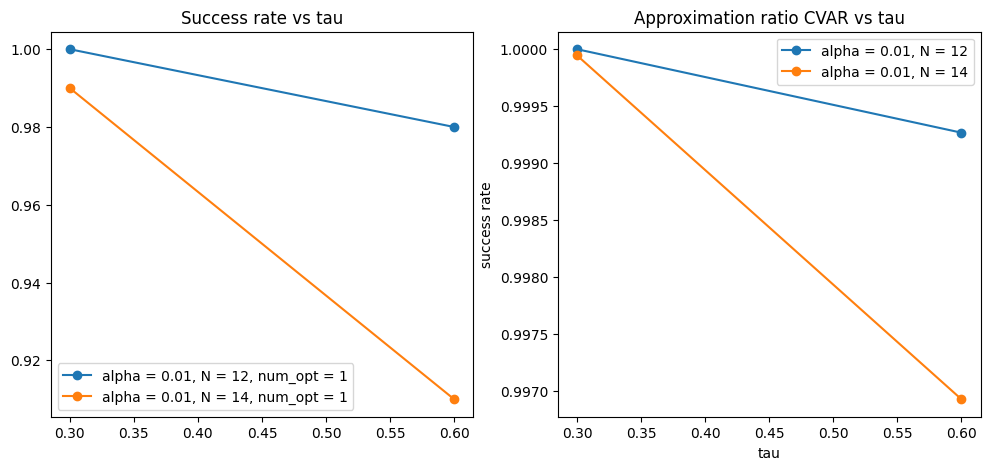

In [46]:
num_variables_list = [str(num).zfill(3) for num in range(12,16, 2)] 

r_list = range(100)
tau_list = [0.3, 0.6]
alpha_list = [0.01]

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)


ansatz_type = 'structure_like_qubo_YZ_2' 

layer = 1

shots = None

initialization = 'warm_start_measure'

tot_steps = range(5)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

for num_variables in num_variables_list:
    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for alpha in alpha_list:
        sr_array = np.zeros((len(num_opt_list), len(tau_list)))
        ar_array = np.zeros(len(tau_list))

        for taui, tau in enumerate(tau_list):
            print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N)

            dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                                .format(num_variables, num_params, layer, alpha, initialization)
            
            for r in r_list:
                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                
                file_dir_name = dir_name + '/r_{}'\
                            .format(r)
                
                filename = file_dir_name + '/tau_{}_random.pkl'\
                                                        .format(tau)
                with open(filename, 'rb') as f:
                    data = pickle.load(f)

                params_list = data["params_list"]
                if len(params_list) != round(N**2):
                    print("error N, r = ", r, len(params_list))
                    
                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                
                final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                poss_list = list(final_exp_poss.values())
                if poss_list[0] > alpha:
                    sr_array[0, taui] += 1/len(r_list)
                if sum(poss_list[:2]) > alpha:
                    sr_array[1, taui] += 1/len(r_list)
                if sum(poss_list[:3]) > alpha:
                    sr_array[2, taui] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                ar_array[taui] += (cvar/exp_opt) / len(r_list)

        print("sr_array = ", sr_array)
        ax1.plot(tau_list, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, num_opt = 1")
        # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
        # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(tau_list, ar_array, "o-", label=f"alpha = {alpha}, N = {N}")
        print("ar_array = ", ar_array)

        ax1.set_title('Success rate vs tau')
        ax2.set_title('Approximation ratio CVAR vs tau')

        ax1.legend()
plt.legend()
plt.xlabel("tau")
plt.ylabel("success rate")
plt.show()




 step =  0 tau =  0.3 alpha =  0.01 N = 12

 step =  1 tau =  0.3 alpha =  0.01 N = 12

 step =  2 tau =  0.3 alpha =  0.01 N = 12

 step =  3 tau =  0.3 alpha =  0.01 N = 12

 step =  4 tau =  0.3 alpha =  0.01 N = 12
sr_array =  [[0.98 1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.  ]]
ar_array =  [0.9999748 1.        1.        1.        1.       ]

 step =  0 tau =  0.3 alpha =  0.01 N = 14

 step =  1 tau =  0.3 alpha =  0.01 N = 14

 step =  2 tau =  0.3 alpha =  0.01 N = 14

 step =  3 tau =  0.3 alpha =  0.01 N = 14

 step =  4 tau =  0.3 alpha =  0.01 N = 14
sr_array =  [[0.74 0.99 0.99 0.99 0.99]
 [0.97 1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.  ]]
ar_array =  [0.99810715 0.99995178 0.99994522 0.99994522 0.99994522]

 step =  0 tau =  0.3 alpha =  0.01 N = 16

 step =  1 tau =  0.3 alpha =  0.01 N = 16

 step =  2 tau =  0.3 alpha =  0.01 N = 16

 step =  3 tau =  0.3 alpha =  0.01 N = 16

 step =  4 tau =  0.3 alpha =  0.01 N = 16
sr_array =  [

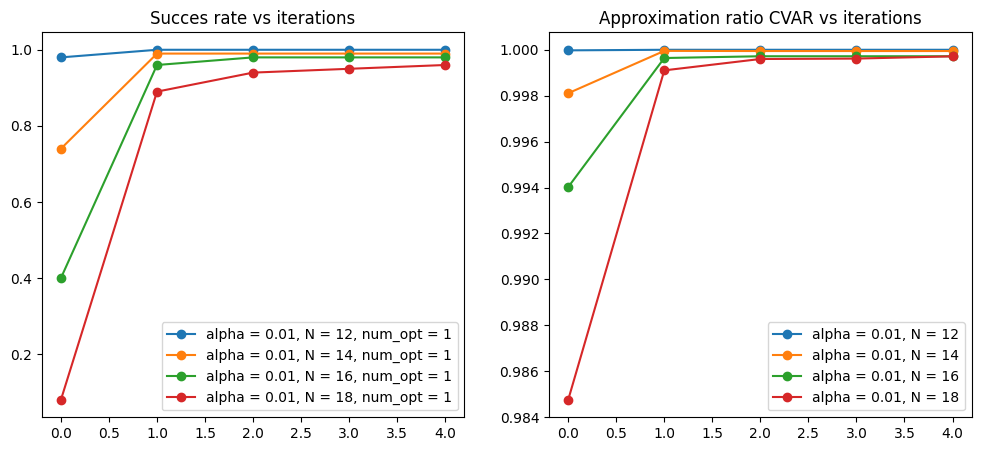

In [60]:


r_list = range(100)
tau_list = [0.3]
alpha_list = [0.01]

tot_steps = range(5)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(12,20, 2)] 

for num_variables in num_variables_list:
    
    
    sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
    ar_array = np.zeros(len(tot_steps))


    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for step in tot_steps:
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"

            file_dir_name = dir_name + '/r_{}'\
                                .format(r)
            
            filename = file_dir_name + '/tau_{}_random.pkl'.format(tau)
                            
            with open(filename, 'rb') as f:
                data = pickle.load(f)

            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))

            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]

            final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]
            # print(len( steps_exp_poss_dict[f"step_{step}"]["l_1"]))
            # print( steps_exp_poss_dict[f"step_{step}"]["l_1"])
            poss_list = list(final_exp_poss.values())
            #print(len(poss_list))
            # print(poss_list)
            if poss_list[0] > alpha:
                sr_array[0, step] += 1/len(r_list)
            if sum(poss_list[:2]) > alpha:
                sr_array[1, step] += 1/len(r_list)
            if sum(poss_list[:3]) > alpha:
                sr_array[2, step] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            #print(exp_opt)
            cvar = steps_cvar_dict[f"step_{step}"]
            #print(cvar)
            ar_array[step] += (cvar/exp_opt) / len(r_list)

    print("sr_array = ", sr_array)
    ax1.plot(tot_steps, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, num_opt = 1")
    # ax1.plot(tot_steps, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tot_steps, ar_array, "o-", label=f"alpha = {alpha}, N = {N}")

    ax1.set_title('Succes rate vs iterations')
    ax2.set_title('Approximation ratio CVAR vs iterations')

    ax1.legend()
    print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()

ITE ADAP


tau =  0.3 alpha =  0.01 qubits =  12

tau =  0.6 alpha =  0.01 qubits =  12
sr_array =  [[1.   0.97]
 [1.   0.99]
 [1.   0.99]]
ar_array =  [1.         0.99786697]

tau =  0.3 alpha =  0.01 qubits =  14

tau =  0.6 alpha =  0.01 qubits =  14
sr_array =  [[1.   0.94]
 [1.   0.98]
 [1.   1.  ]]
ar_array =  [1.         0.99799735]


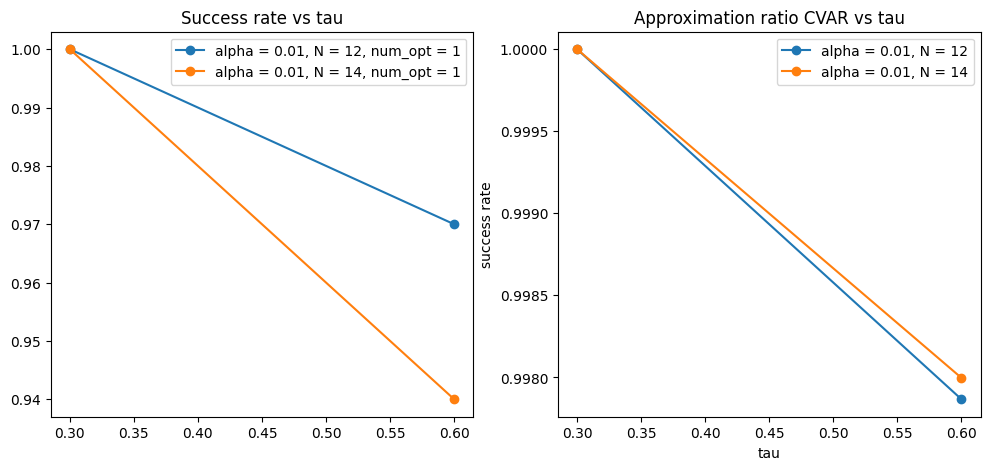

In [49]:

num_variables_list = [str(num).zfill(3) for num in range(12,16, 2)] 

r_list = range(100)
tau_list = [0.3, 0.6]
alpha_list = [0.01]

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)


ansatz_type = 'structure_like_qubo_YZ_2' 

layer = 1

shots = None

initialization = 'warm_start_measure'

tot_steps = range(5)

dir_0 = './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

for num_variables in num_variables_list:
    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for alpha in alpha_list:
        sr_array = np.zeros((len(num_opt_list), len(tau_list)))
        ar_array = np.zeros(len(tau_list))

        for taui, tau in enumerate(tau_list):
            print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N)

            dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                                .format(num_variables, num_params, layer, alpha, initialization)
            
            for r in r_list:
                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                
                file_dir_name = dir_name + '/r_{}'\
                            .format(r)
                
                filename = file_dir_name + '/tau_{}.pkl'\
                                                        .format(tau)
                with open(filename, 'rb') as f:
                    data = pickle.load(f)

                params_list = data["params_list"]
                if len(params_list) != round(N**2):
                    print("error N, r = ", r, len(params_list))
                    
                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                
                final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                poss_list = list(final_exp_poss.values())
                if poss_list[0] > alpha:
                    sr_array[0, taui] += 1/len(r_list)
                if sum(poss_list[:2]) > alpha:
                    sr_array[1, taui] += 1/len(r_list)
                if sum(poss_list[:3]) > alpha:
                    sr_array[2, taui] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                ar_array[taui] += (cvar/exp_opt) / len(r_list)

        print("sr_array = ", sr_array)
        ax1.plot(tau_list, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, num_opt = 1")
        # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
        # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(tau_list, ar_array, "o-", label=f"alpha = {alpha}, N = {N}")
        print("ar_array = ", ar_array)

        ax1.set_title('Success rate vs tau')
        ax2.set_title('Approximation ratio CVAR vs tau')

        ax1.legend()
plt.legend()
plt.xlabel("tau")
plt.ylabel("success rate")
plt.show()


 step =  0 tau =  0.3 alpha =  0.01 N = 12

 step =  1 tau =  0.3 alpha =  0.01 N = 12

 step =  2 tau =  0.3 alpha =  0.01 N = 12

 step =  3 tau =  0.3 alpha =  0.01 N = 12

 step =  4 tau =  0.3 alpha =  0.01 N = 12
sr_array =  [[0.93 1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.  ]]
ar_array =  [0.99978858 1.         1.         1.         1.        ]

 step =  0 tau =  0.3 alpha =  0.01 N = 14

 step =  1 tau =  0.3 alpha =  0.01 N = 14

 step =  2 tau =  0.3 alpha =  0.01 N = 14

 step =  3 tau =  0.3 alpha =  0.01 N = 14

 step =  4 tau =  0.3 alpha =  0.01 N = 14
sr_array =  [[0.8  1.   1.   1.   1.  ]
 [0.99 1.   1.   1.   1.  ]
 [1.   1.   1.   1.   1.  ]]
ar_array =  [0.99863682 1.         1.         1.         1.        ]

 step =  0 tau =  0.3 alpha =  0.01 N = 16

 step =  1 tau =  0.3 alpha =  0.01 N = 16

 step =  2 tau =  0.3 alpha =  0.01 N = 16

 step =  3 tau =  0.3 alpha =  0.01 N = 16

 step =  4 tau =  0.3 alpha =  0.01 N = 16
sr_array

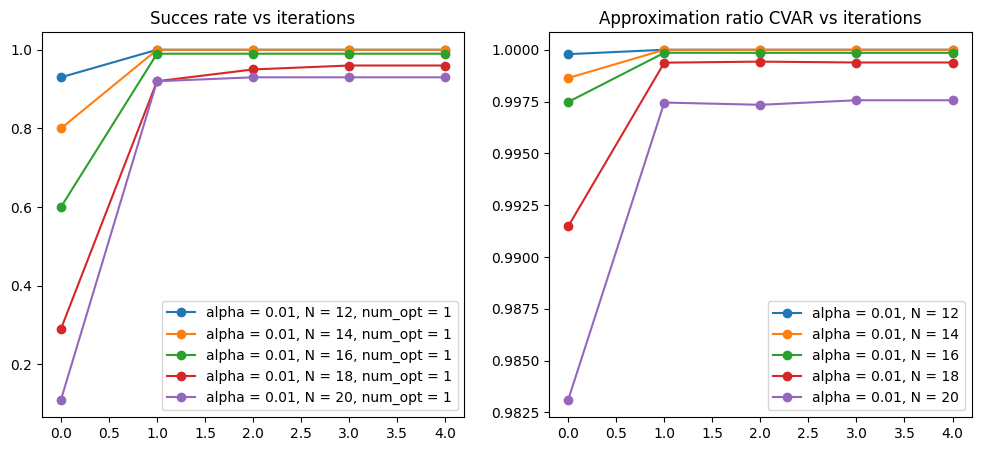

In [59]:


r_list = range(100)
tau_list = [0.3]
alpha_list = [0.01]

tot_steps = range(5)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(12,22, 2)] 

for num_variables in num_variables_list:
    
    
    sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
    ar_array = np.zeros(len(tot_steps))


    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for step in tot_steps:
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"

            file_dir_name = dir_name + '/r_{}'\
                                .format(r)
            
            filename = file_dir_name + '/tau_{}.pkl'.format(tau)
                            
            with open(filename, 'rb') as f:
                data = pickle.load(f)

            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))

            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]

            final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]
            # print(len( steps_exp_poss_dict[f"step_{step}"]["l_1"]))
            # print( steps_exp_poss_dict[f"step_{step}"]["l_1"])
            poss_list = list(final_exp_poss.values())
            #print(len(poss_list))
            # print(poss_list)
            if poss_list[0] > alpha:
                sr_array[0, step] += 1/len(r_list)
            if sum(poss_list[:2]) > alpha:
                sr_array[1, step] += 1/len(r_list)
            if sum(poss_list[:3]) > alpha:
                sr_array[2, step] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            #print(exp_opt)
            cvar = steps_cvar_dict[f"step_{step}"]
            #print(cvar)
            ar_array[step] += (cvar/exp_opt) / len(r_list)

    print("sr_array = ", sr_array)
    ax1.plot(tot_steps, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, num_opt = 1")
    # ax1.plot(tot_steps, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tot_steps, ar_array, "o-", label=f"alpha = {alpha}, N = {N}")

    ax1.set_title('Succes rate vs iterations')
    ax2.set_title('Approximation ratio CVAR vs iterations')

    ax1.legend()
    print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()

COMPARE ADAP AND RANDOM



 step =  0 tau =  0.3 alpha =  0.01 N = 16

 step =  1 tau =  0.3 alpha =  0.01 N = 16

 step =  2 tau =  0.3 alpha =  0.01 N = 16

 step =  3 tau =  0.3 alpha =  0.01 N = 16

 step =  4 tau =  0.3 alpha =  0.01 N = 16
sr_array =  [[0.4  0.96 0.98 0.98 0.98]
 [0.6  0.99 0.99 0.99 0.99]
 [0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99402018 0.99964078 0.99971794 0.99971794 0.99971794]
 [0.99748117 0.99985632 0.99985202 0.99985202 0.99985202]
 [0.         0.         0.         0.         0.        ]]

 step =  0 tau =  0.3 alpha =  0.01 N = 18

 step =  1 tau =  0.3 alpha =  0.01 N = 18

 step =  2 tau =  0.3 alpha =  0.01 N = 18

 step =  3 tau =  0.3 alpha =  0.01 N = 18

 step =  4 tau =  0.3 alpha =  0.01 N = 18
sr_array =  [[0.08 0.89 0.94 0.95 0.96]
 [0.29 0.92 0.95 0.96 0.96]
 [0.   0.   0.   0.   0.  ]]
ar_array =  [[0.98475314 0.99910297 0.99959834 0.9996164  0.99971446]
 [0.99147621 0.9993777  0.99942854 0.99938584 0.99938582]
 [0.         0.         0.         0.         0.   

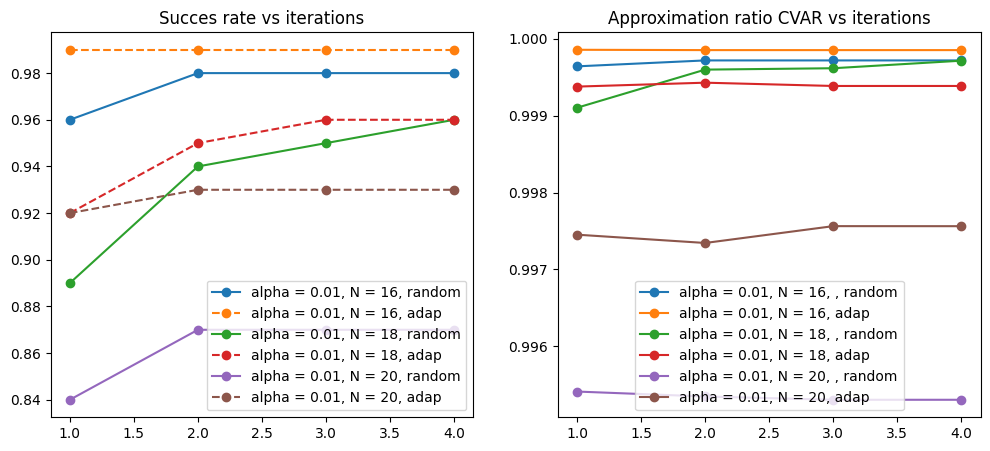

In [133]:
r_list = range(100)
tau_list = [0.3]
alpha_list = [0.01]

tot_steps = range(5)


num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

tau_list = [0.3, 0.6] 

num_variables_list = [str(num).zfill(3) for num in range(16,22, 2)] 

for num_variables in num_variables_list:
    
    tot_steps = range(5) 

    sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
    ar_array = np.zeros((len(num_opt_list), len(tot_steps)))


    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for step in tot_steps:
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"

            file_dir_name = dir_name + '/r_{}'\
                                .format(r)
            
            filename = dir_0 + file_dir_name + '/tau_{}_random.pkl'.format(tau)
                            
            with open(filename, 'rb') as f:
                data = pickle.load(f)

            filename_adap = dir_0_adap + file_dir_name + '/tau_{}.pkl'.format(tau)
                            
            with open(filename_adap, 'rb') as f:
                data_adap = pickle.load(f)

            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))

            params_list = data_adap["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))

            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]
            final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]  
            poss_list = list(final_exp_poss.values())

            steps_exp_poss_dict_adap = data_adap["steps_exp_poss_dict"]
            steps_cvar_dict_adap = data_adap["steps_cvar_dict"]
            final_exp_poss_adap = steps_exp_poss_dict_adap[f"step_{step}"]["l_1"]
            poss_list_adap = list(final_exp_poss_adap.values())


            if poss_list[0] > alpha:
                sr_array[0, step] += 1/len(r_list)
            if poss_list_adap[0] > alpha:
                sr_array[1, step] += 1/len(r_list)

            # if sum(poss_list[:3]) > alpha:
            #     sr_array[2, step] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            cvar = steps_cvar_dict[f"step_{step}"]

            ar_array[0,step] += (cvar/exp_opt) / len(r_list)

            exp_opt = list(final_exp_poss_adap.keys())[0]
            cvar = steps_cvar_dict_adap[f"step_{step}"]

            ar_array[1,step] += (cvar/exp_opt) / len(r_list)

    tot_steps = range(1,5)
    
    print("sr_array = ", sr_array)
    ax1.plot(tot_steps, sr_array[0][1:], "o-", label=f"alpha = {alpha}, N = {N}, random")
    ax1.plot(tot_steps, sr_array[1][1:], "o--",label=f"alpha = {alpha}, N = {N}, adap")
    # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tot_steps, ar_array[0][1:], "o-", label=f"alpha = {alpha}, N = {N}, , random")
    ax2.plot(tot_steps, ar_array[1][1:], "o-", label=f"alpha = {alpha}, N = {N}, adap")

    ax1.set_title('Succes rate vs iterations')
    ax2.set_title('Approximation ratio CVAR vs iterations')

    ax1.legend()
    print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  4 tau =  0.3 alpha =  0.01 N = 16

 step =  4 tau =  0.6 alpha =  0.01 N = 16
sr_array =  [[0.98 0.8 ]
 [0.99 0.9 ]
 [0.   0.  ]]
ar_array =  [[0.99971794 0.99048889]
 [0.99985202 0.99681511]
 [0.         0.        ]]

 step =  4 tau =  0.3 alpha =  0.01 N = 18

 step =  4 tau =  0.6 alpha =  0.01 N = 18
sr_array =  [[0.96 0.66]
 [0.96 0.79]
 [0.   0.  ]]
ar_array =  [[0.99971446 0.98513275]
 [0.99938582 0.99419626]
 [0.         0.        ]]

 step =  4 tau =  0.3 alpha =  0.01 N = 20

 step =  4 tau =  0.6 alpha =  0.01 N = 20
sr_array =  [[0.87 0.7 ]
 [0.93 0.8 ]
 [0.   0.  ]]
ar_array =  [[0.99530628 0.9845846 ]
 [0.99756299 0.99229514]
 [0.         0.        ]]


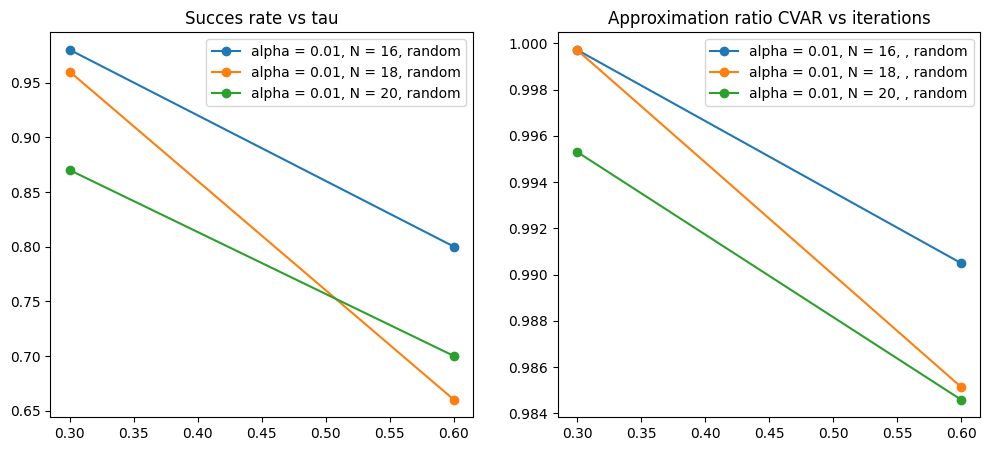

In [117]:
r_list = range(100)
tau_list = [0.3,0.6]
alpha_list = [0.01]

tot_steps = range(5)


num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(16,22, 2)] 

for num_variables in num_variables_list:


    sr_array = np.zeros((len(num_opt_list), len(tau_list)))
    ar_array = np.zeros((len(num_opt_list), len(tau_list)))


    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for taui, tau in enumerate(tau_list):
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)

        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"

            file_dir_name = dir_name + '/r_{}'\
                                .format(r)
            
            filename = dir_0 + file_dir_name + '/tau_{}_random.pkl'.format(tau)
                            
            with open(filename, 'rb') as f:
                data = pickle.load(f)

            filename_adap = dir_0_adap + file_dir_name + '/tau_{}.pkl'.format(tau)
                            
            with open(filename_adap, 'rb') as f:
                data_adap = pickle.load(f)

            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))

            params_list = data_adap["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))

            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]
            final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
            poss_list = list(final_exp_poss.values())

            steps_exp_poss_dict_adap = data_adap["steps_exp_poss_dict"]
            steps_cvar_dict_adap = data_adap["steps_cvar_dict"]
            final_exp_poss_adap = steps_exp_poss_dict_adap[f"step_{len(tot_steps)-1}"]["l_1"]
            poss_list_adap = list(final_exp_poss_adap.values())


            if poss_list[0] > alpha:
                sr_array[0, taui] += 1/len(r_list)
            if poss_list_adap[0] > alpha:
                sr_array[1, taui] += 1/len(r_list)

            # if sum(poss_list[:3]) > alpha:
            #     sr_array[2, step] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]

            ar_array[0,taui] += (cvar/exp_opt) / len(r_list)

            exp_opt = list(final_exp_poss_adap.keys())[0]
            cvar = steps_cvar_dict_adap[f"step_{len(tot_steps)-1}"]

            ar_array[1,taui] += (cvar/exp_opt) / len(r_list)

    
    print("sr_array = ", sr_array)
    ax1.plot(tau_list, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, random")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, N = {N}, adap")
    # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tau_list, ar_array[0], "o-", label=f"alpha = {alpha}, N = {N}, , random")
    # ax2.plot(tau_list, ar_array[1], "o-", label=f"alpha = {alpha}, N = {N}, adap")

    ax1.set_title('Succes rate vs tau')
    ax2.set_title('Approximation ratio CVAR vs iterations')

    ax1.legend()
    print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()

COMPARE ALL SORTING


 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.03 0.84 0.87 0.87 0.87]
 [0.06 0.85 0.92 0.93 0.93]
 [0.04 0.83 0.87 0.88 0.89]
 [0.03 0.78 0.9  0.9  0.9 ]
 [0.03 0.81 0.9  0.91 0.91]
 [0.11 0.92 0.93 0.93 0.93]]
ar_array =  [[0.97317182 0.99541322 0.99534904 0.99530629 0.99530628]
 [0.97691011 0.99705865 0.99784908 0.99790008 0.99790008]
 [0.97219816 0.99408728 0.99570863 0.9961429  0.99625651]
 [0.97024725 0.99681687 0.99811657 0.99811328 0.99811328]
 [0.97544562 0.99712407 0.99778036 0.99777376 0.99799523]
 [0.983107   0.99745258 0.99734476 0.99756363 0.99756299]]
sr_array =  [[0.03 0.84 0.87 0.87 0.87]
 [0.06 0.85 0.92 0.93 0.93]
 [0.04 0.83 0.87 0.88 0.89]
 [0.03 0.78 0.9  0.9  0.9 ]
 [0.03 0.81 0.9  0.91 0.91]
 [0.11 0.92 0.93 0.93 0.93]]
ar_array =  [[0.97317182 0.99541322 0.99534904 0.99530629 0.99530628]
 [0.97691011 0.99705865 0.99784908 0.99790008 0.99790008]
 [0.97219816 0.99408728 0.99570863 0.9961429  0.99625651]
 [0.97024725 0.99681687 0.99811657 0.99811328 0

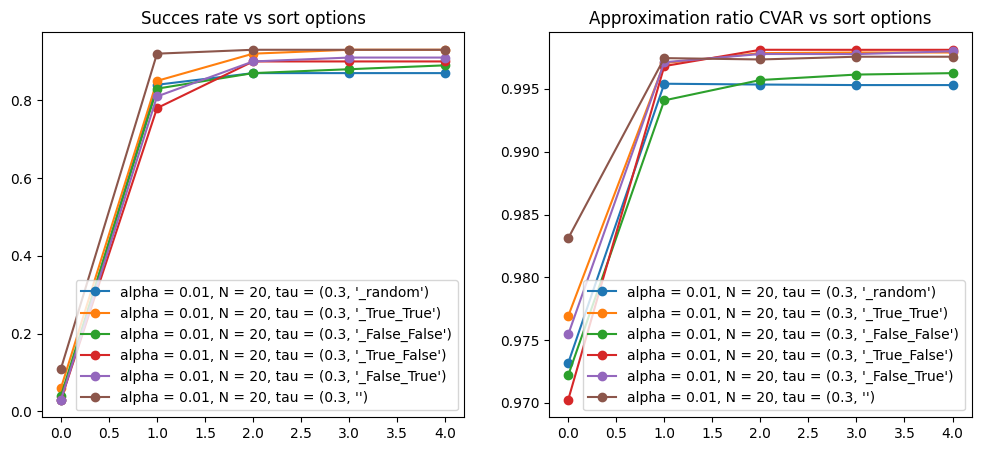

In [134]:
r_list = range(100)
tau_list = [0.3]
alpha_list = [0.01]

tot_steps = range(5)

sortoptions = ['_random', '_True_True', '_False_False', '_True_False', '_False_True', '']

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 

for num_variables in num_variables_list:



    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for taui, tau in enumerate(tau_list):
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        sr_array = np.zeros((len(sortoptions), len(tot_steps)))
        ar_array = np.zeros((len(sortoptions), len(tot_steps)))

        for step in tot_steps:
            for r in r_list:
                # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                
                for optioni,option in enumerate(sortoptions):

                    file_dir_name = dir_name + '/r_{}'\
                                        .format(r)
                    
                    
                    if option == '':
                        filename = dir_0_adap + file_dir_name + '/tau_{}{}.pkl'.format(tau, option)
                                        
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                    else:
                        filename = dir_0 + file_dir_name + '/tau_{}{}.pkl'.format(tau,option)
                                        
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(N**2):
                        print("error N, r = ", r, len(params_list))

                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]
                    poss_list = list(final_exp_poss.values())

                    if poss_list[0] > alpha:
                        sr_array[optioni, step] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{step}"]

                    ar_array[optioni,step] += (cvar/exp_opt) / len(r_list)
        
        for optioni, option in enumerate(sortoptions):
            print("sr_array = ", sr_array)
            ax1.plot(tot_steps, sr_array[optioni], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau, option}")
            # ax1.plot(range(sortoptions), sr_array[1], "o--",label=f"alpha = {alpha}, N = {N}, adap")
            # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

            ax2.plot(tot_steps, ar_array[optioni], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau, option}")
            # ax2.plot(range(sortoptions), ar_array[1], "o-", label=f"alpha = {alpha}, N = {N}, adap")

            ax1.set_title('Succes rate vs sort options')
            ax2.set_title('Approximation ratio CVAR vs sort options')

            ax1.legend()
            print("ar_array = ", ar_array)

plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.87 0.93 0.89 0.9  0.91 0.93]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99530628 0.99790008 0.99625651 0.99811328 0.99799523 0.99756299]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]

 step =  4 tau =  0.6 alpha =  0.01 N = 20
sr_array =  [[0.7  0.7  0.59 0.68 0.7  0.8 ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.9845846  0.98484353 0.97981234 0.9812404  0.98508647 0.99229514]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


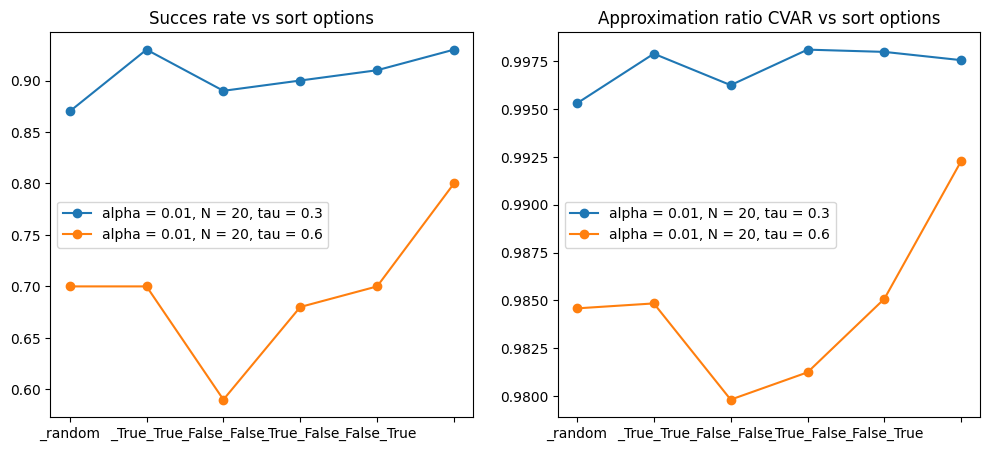

In [107]:
r_list = range(100)
tau_list = [0.3, 0.6]
alpha_list = [0.01]

tot_steps = range(5)

sortoptions = ['_random', '_True_True', '_False_False', '_True_False', '_False_True', '']

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(20,22, 2)] 

for num_variables in num_variables_list:



    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for taui, tau in enumerate(tau_list):
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        sr_array = np.zeros((len(num_opt_list), len(sortoptions)))
        ar_array = np.zeros((len(num_opt_list), len(sortoptions)))

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
            
            for optioni,option in enumerate(sortoptions):
                file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                
                
                if option == '':
                    filename = dir_0_adap + file_dir_name + '/tau_{}{}.pkl'.format(tau, option)
                                    
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                else:
                    filename = dir_0 + file_dir_name + '/tau_{}{}.pkl'.format(tau,option)
                                    
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                params_list = data["params_list"]
                if len(params_list) != round(N**2):
                    print("error N, r = ", r, len(params_list))


                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                poss_list = list(final_exp_poss.values())

                if poss_list[0] > alpha:
                    sr_array[0, optioni] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]

                ar_array[0,optioni] += (cvar/exp_opt) / len(r_list)
        
        print("sr_array = ", sr_array)
        ax1.plot(sortoptions, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau}")
        # ax1.plot(range(sortoptions), sr_array[1], "o--",label=f"alpha = {alpha}, N = {N}, adap")
        # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(sortoptions, ar_array[0], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau}")
        # ax2.plot(range(sortoptions), ar_array[1], "o-", label=f"alpha = {alpha}, N = {N}, adap")

        ax1.set_title('Succes rate vs sort options')
        ax2.set_title('Approximation ratio CVAR vs sort options')

        ax1.legend()
        print("ar_array = ", ar_array)

plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  4 tau =  0.3 alpha =  0.01 N = 16
sr_array =  [[0.98 0.97 0.97 0.98 0.97 0.99]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99971794 0.9995134  0.99967675 0.9997247  0.99935139 0.99985202]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]

 step =  4 tau =  0.3 alpha =  0.01 N = 18
sr_array =  [[0.96 0.94 0.94 0.93 0.93 0.96]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99971446 0.99788095 0.99915737 0.99882904 0.99831035 0.99938582]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]

 step =  4 tau =  0.3 alpha =  0.01 N = 20
sr_array =  [[0.87 0.93 0.89 0.9  0.91 0.93]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
ar_array =  [[0.99530628 0.99790008 0.99625651 0.99811328 0.99799523 0.99756299]
 [0.       

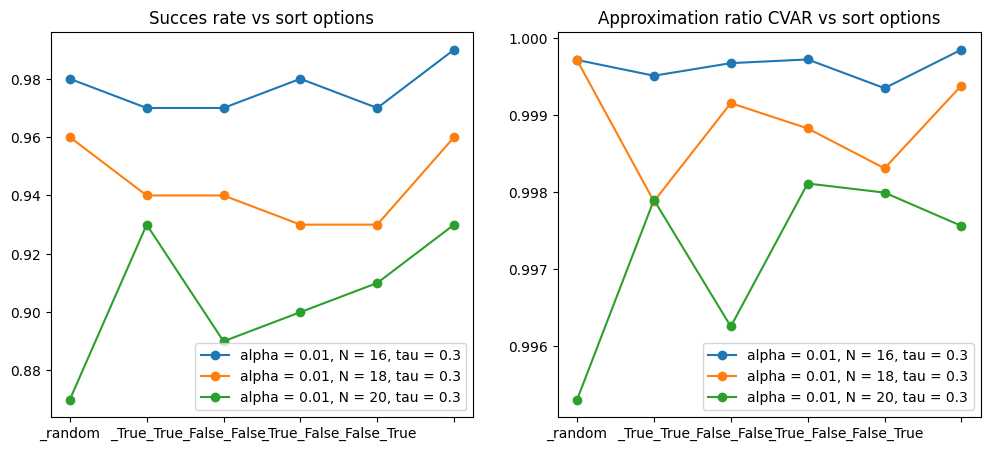

In [135]:
r_list = range(100)
tau_list = [0.3]
alpha_list = [0.01]

tot_steps = range(5)

sortoptions = ['_random', '_True_True', '_False_False', '_True_False', '_False_True', '']

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

dir_0 = './data_iter' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

dir_0_adap =  './data_iter_adap_sorting' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)

alpha = 0.01 
tau = 0.3

num_variables_list = [str(num).zfill(3) for num in range(16,22, 2)] 

for num_variables in num_variables_list:



    n_qubits = int(num_variables)

    N = n_qubits

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    for taui, tau in enumerate(tau_list):
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha, "N =", N)

        sr_array = np.zeros((len(num_opt_list), len(sortoptions)))
        ar_array = np.zeros((len(num_opt_list), len(sortoptions)))

        dir_name =  '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                    .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in r_list:
            # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
            
            for optioni,option in enumerate(sortoptions):
                file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                
                
                if option == '':
                    filename = dir_0_adap + file_dir_name + '/tau_{}{}.pkl'.format(tau, option)
                                    
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                else:
                    filename = dir_0 + file_dir_name + '/tau_{}{}.pkl'.format(tau,option)
                                    
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                params_list = data["params_list"]
                if len(params_list) != round(N**2):
                    print("error N, r = ", r, len(params_list))


                steps_exp_poss_dict = data["steps_exp_poss_dict"]
                steps_cvar_dict = data["steps_cvar_dict"]
                final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                poss_list = list(final_exp_poss.values())

                if poss_list[0] > alpha:
                    sr_array[0, optioni] += 1/len(r_list)

                exp_opt = list(final_exp_poss.keys())[0]
                cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]

                ar_array[0,optioni] += (cvar/exp_opt) / len(r_list)
        
        print("sr_array = ", sr_array)
        ax1.plot(sortoptions, sr_array[0], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau}")
        # ax1.plot(range(sortoptions), sr_array[1], "o--",label=f"alpha = {alpha}, N = {N}, adap")
        # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

        ax2.plot(sortoptions, ar_array[0], "o-", label=f"alpha = {alpha}, N = {N}, tau = {tau}")
        # ax2.plot(range(sortoptions), ar_array[1], "o-", label=f"alpha = {alpha}, N = {N}, adap")

        ax1.set_title('Succes rate vs sort options')
        ax2.set_title('Approximation ratio CVAR vs sort options')

        ax1.legend()
        print("ar_array = ", ar_array)

plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()

STOP HERE!!!!!!!!!!!!!!!!!!!!!


tau =  0.05 alpha =  0.01

tau =  0.1 alpha =  0.01

tau =  0.2 alpha =  0.01

tau =  0.4 alpha =  0.01

tau =  0.6 alpha =  0.01
sr_array =  [[0.78 0.88 0.89 0.83 0.7 ]
 [0.89 0.94 0.96 0.88 0.78]
 [0.92 0.97 0.99 0.91 0.82]]
ar_array =  [0.99113628 0.99661714 0.99751693 0.99398891 0.98458413]


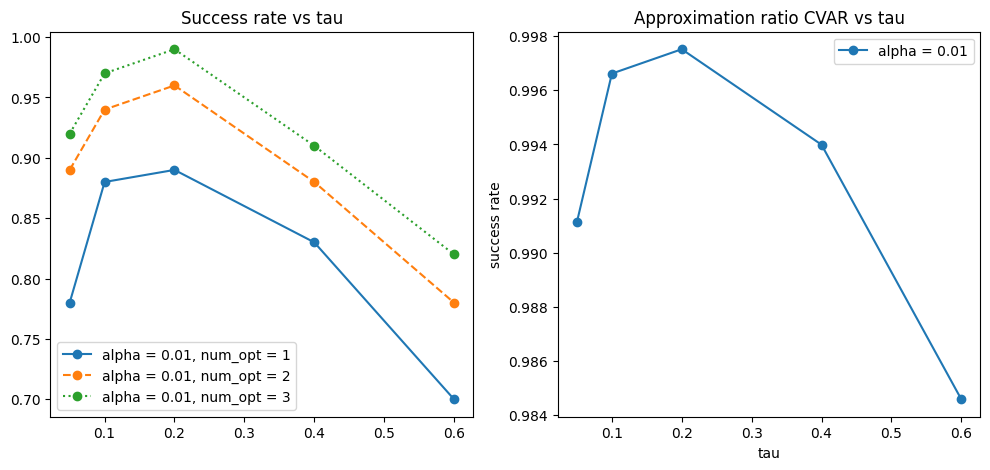

In [69]:
N=20
r_list = range(100)
tau_list = [0.05, 0.1, 0.2, 0.4, 0.6]
alpha_list = [0.01]

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
for alpha in alpha_list:
    sr_array = np.zeros((len(num_opt_list), len(tau_list)))
    ar_array = np.zeros(len(tau_list))
    for taui, tau in enumerate(tau_list):
        print("\ntau = ", tau, "alpha = ", alpha)
        for r in r_list:
            filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))
            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]
            
            final_exp_poss = steps_exp_poss_dict["step_5"]["l_1"]
            poss_list = list(final_exp_poss.values())
            if poss_list[0] > alpha:
                sr_array[0, taui] += 1/len(r_list)
            if sum(poss_list[:2]) > alpha:
                sr_array[1, taui] += 1/len(r_list)
            if sum(poss_list[:3]) > alpha:
                sr_array[2, taui] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            cvar = steps_cvar_dict["step_9"]
            ar_array[taui] += (cvar/exp_opt) / len(r_list)

    print("sr_array = ", sr_array)
    ax1.plot(tau_list, sr_array[0], "o-", label=f"alpha = {alpha}, num_opt = 1")
    ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tau_list, ar_array, "o-", label=f"alpha = {alpha}")
    print("ar_array = ", ar_array)

    ax1.set_title('Success rate vs tau')
    ax2.set_title('Approximation ratio CVAR vs tau')

    ax1.legend()
plt.legend()
plt.xlabel("tau")
plt.ylabel("success rate")
plt.show()



In [45]:
steps_exp_poss_dict.keys()

dict_keys(['step_0', 'step_1', 'step_2', 'step_3', 'step_4', 'step_5', 'step_6', 'step_7', 'step_8', 'step_9'])


 step =  0 tau =  0.2 alpha =  0.01

 step =  1 tau =  0.2 alpha =  0.01

 step =  2 tau =  0.2 alpha =  0.01

 step =  3 tau =  0.2 alpha =  0.01

 step =  4 tau =  0.2 alpha =  0.01

 step =  5 tau =  0.2 alpha =  0.01

 step =  6 tau =  0.2 alpha =  0.01

 step =  7 tau =  0.2 alpha =  0.01

 step =  8 tau =  0.2 alpha =  0.01

 step =  9 tau =  0.2 alpha =  0.01
sr_array =  [[0.   0.82 0.88 0.89 0.89 0.89 0.89 0.89 0.89 0.89]
 [0.   0.89 0.92 0.95 0.95 0.96 0.96 0.96 0.96 0.96]
 [0.   0.94 0.97 0.99 0.99 0.99 0.99 0.99 0.99 0.99]]
ar_array =  [0.95654325 0.99600428 0.99727966 0.99754692 0.99749912 0.99751693
 0.99751693 0.99751693 0.99751693 0.99751693]


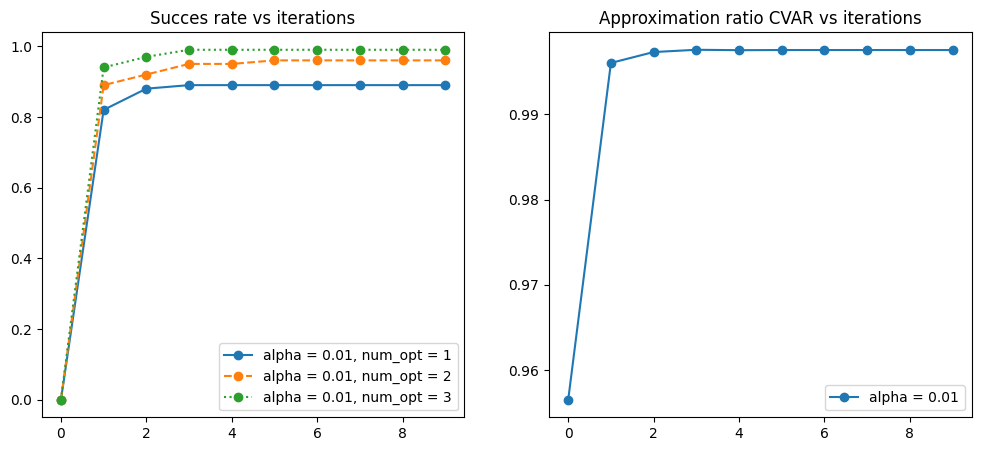

In [70]:
N=20
r_list = range(100)
tau_list = [0.6]
alpha_list = [0.01]

tot_steps = range(10)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
ar_array = np.zeros(len(tot_steps))

alpha = 0.01 
tau = 0.2

for step in tot_steps:
    print("\n step = ", step, "tau = ", tau, "alpha = ", alpha)
    for r in r_list:
        filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        params_list = data["params_list"]
        if len(params_list) != round(N**2):
            print("error N, r = ", r, len(params_list))
        steps_exp_poss_dict = data["steps_exp_poss_dict"]
        steps_cvar_dict = data["steps_cvar_dict"]
        
        final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]
        # print(len( steps_exp_poss_dict[f"step_{step}"]["l_1"]))
        # print( steps_exp_poss_dict[f"step_{step}"]["l_1"])
        poss_list = list(final_exp_poss.values())
        # print(len(poss_list))
        # print(poss_list)
        if poss_list[0] > alpha:
            sr_array[0, step] += 1/len(r_list)
        if sum(poss_list[:2]) > alpha:
            sr_array[1, step] += 1/len(r_list)
        if sum(poss_list[:3]) > alpha:
            sr_array[2, step] += 1/len(r_list)

        exp_opt = list(final_exp_poss.keys())[0]
        # print(exp_opt)
        cvar = steps_cvar_dict[f"step_{step}"]
        ar_array[step] += (cvar/exp_opt) / len(r_list)

print("sr_array = ", sr_array)
ax1.plot(tot_steps, sr_array[0], "o-", label=f"alpha = {alpha}, num_opt = 1")
ax1.plot(tot_steps, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

ax2.plot(tot_steps, ar_array, "o-", label=f"alpha = {alpha}")

ax1.set_title('Succes rate vs iterations')
ax2.set_title('Approximation ratio CVAR vs iterations')

ax1.legend()
print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()


 step =  0 tau =  0.05 alpha =  0.01

 step =  1 tau =  0.05 alpha =  0.01

 step =  2 tau =  0.05 alpha =  0.01

 step =  3 tau =  0.05 alpha =  0.01

 step =  4 tau =  0.05 alpha =  0.01

 step =  5 tau =  0.05 alpha =  0.01

 step =  6 tau =  0.05 alpha =  0.01

 step =  7 tau =  0.05 alpha =  0.01

 step =  8 tau =  0.05 alpha =  0.01

 step =  9 tau =  0.05 alpha =  0.01
sr_array =  [[0.   0.01 0.58 0.75 0.78 0.78 0.78 0.78 0.78 0.78]
 [0.   0.07 0.69 0.87 0.88 0.89 0.89 0.89 0.89 0.89]
 [0.   0.09 0.76 0.9  0.91 0.92 0.92 0.92 0.92 0.92]]
ar_array =  [0.75121232 0.91097421 0.98177961 0.98982886 0.9904619  0.99058298
 0.99113628 0.99113628 0.99113628 0.99113628]

 step =  0 tau =  0.1 alpha =  0.01

 step =  1 tau =  0.1 alpha =  0.01

 step =  2 tau =  0.1 alpha =  0.01

 step =  3 tau =  0.1 alpha =  0.01

 step =  4 tau =  0.1 alpha =  0.01

 step =  5 tau =  0.1 alpha =  0.01

 step =  6 tau =  0.1 alpha =  0.01

 step =  7 tau =  0.1 alpha =  0.01

 step =  8 tau =  0.1 alph

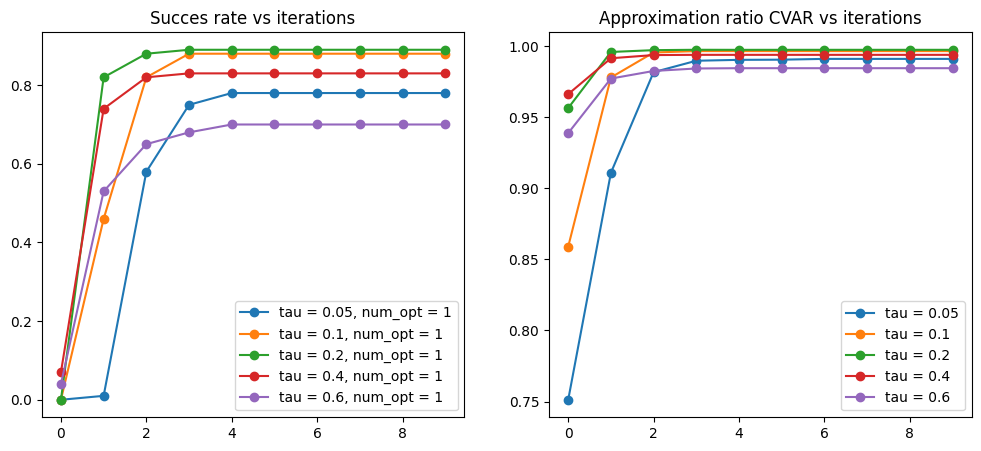

In [67]:
N=20
r_list = range(100)
tau_list = [0.05, 0.1, 0.2, 0.4, 0.6]
alpha_list = [0.01]

tot_steps = range(10)

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

alpha = 0.01 
tau = 0.6

for tau in tau_list:
    sr_array = np.zeros((len(num_opt_list), len(tot_steps)))
    ar_array = np.zeros(len(tot_steps)) 
    for step in tot_steps:
        print("\n step = ", step, "tau = ", tau, "alpha = ", alpha)
        for r in r_list:
            filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            params_list = data["params_list"]
            if len(params_list) != round(N**2):
                print("error N, r = ", r, len(params_list))
            steps_exp_poss_dict = data["steps_exp_poss_dict"]
            steps_cvar_dict = data["steps_cvar_dict"]
            
            final_exp_poss = steps_exp_poss_dict[f"step_{step}"]["l_1"]
            # print(len( steps_exp_poss_dict[f"step_{step}"]["l_1"]))
            # print( steps_exp_poss_dict[f"step_{step}"]["l_1"])
            poss_list = list(final_exp_poss.values())
            # print(len(poss_list))
            # print(poss_list)
            if poss_list[0] > alpha:
                sr_array[0, step] += 1/len(r_list)
            if sum(poss_list[:2]) > alpha:
                sr_array[1, step] += 1/len(r_list)
            if sum(poss_list[:3]) > alpha:
                sr_array[2, step] += 1/len(r_list)

            exp_opt = list(final_exp_poss.keys())[0]
            # print(exp_opt)
            cvar = steps_cvar_dict[f"step_{step}"]
            ar_array[step] += (cvar/exp_opt) / len(r_list)

    print("sr_array = ", sr_array)
    ax1.plot(tot_steps, sr_array[0], "o-", label=f"tau = {tau}, num_opt = 1")
    # ax1.plot(tot_steps, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tot_steps, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(tot_steps, ar_array, "o-", label=f"tau = {tau}")

    ax1.set_title('Succes rate vs iterations')
    ax2.set_title('Approximation ratio CVAR vs iterations')

    ax1.legend()
    print("ar_array = ", ar_array)
plt.legend()
# plt.xlabel("iterations")
# plt.ylabel("success rate")
plt.show()